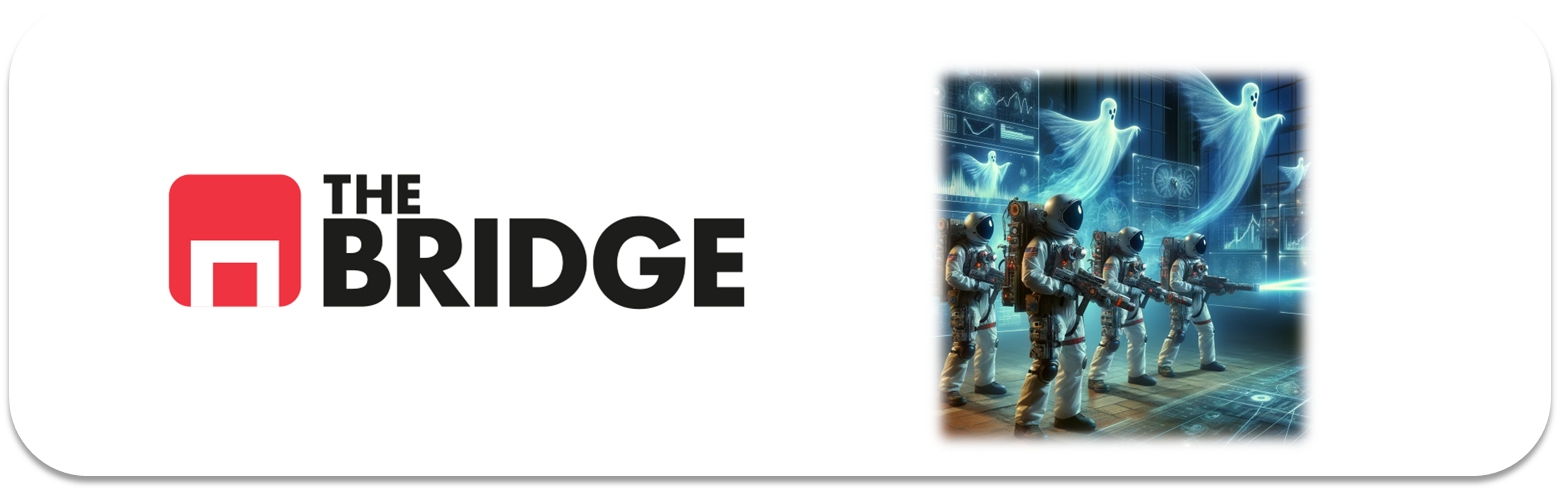

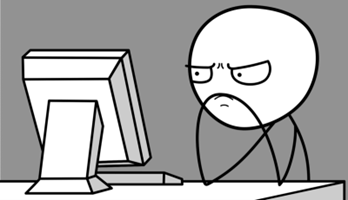

Para ejercitarte y afianzar lo aprendido sobre **Series Temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### El "problema"

Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


### Ejercicio 1

Carga los datos y adecúa el dataset teniendo en cuenta que es una serie temporal. Para ello convierte la columna de fecha al formato adecuado y luego úsala como índice.

In [36]:
df = pd.read_csv("./data/AirPassengers.csv")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [38]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date") # La fecha como índice, que si recuerdas de tiempos antiguos, nos ayudará en Pandas.


In [39]:
df.head()

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Ejercicio 2

¿De qué fecha a qué fecha va el histórico?¿Qué periodicidad tiene la serie?

In [40]:
df.index.min(), df.index.max()

(Timestamp('1949-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00'))

In [41]:
df.index.to_series().diff().value_counts().head()

date
31 days    83
30 days    48
28 days     9
29 days     3
Name: count, dtype: int64

### Ejercicio 3

¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad? Analiza de manera gráfica, pero todavía sin descomponer la serie.

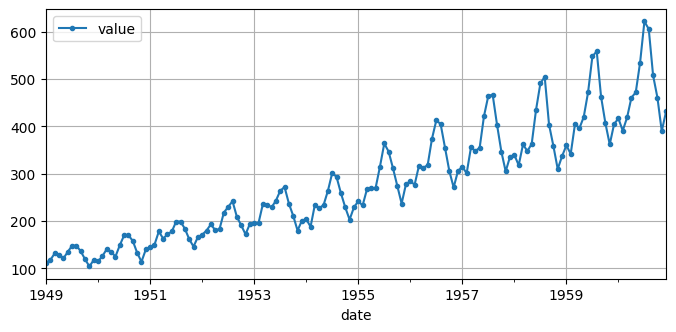

In [42]:
df.plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Muestra estacionalidad anual con tendencia creciente

### Ejercicio 4

¿Podrías demostrar de dos maneras estadísticas que la serie no es estacionaria?

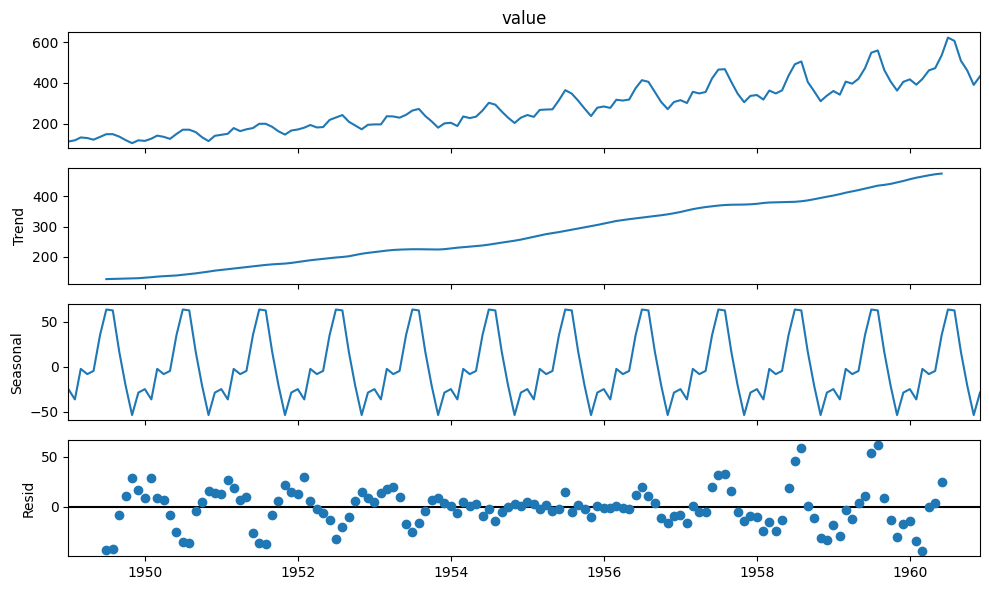

In [43]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['value'], model='additive', period=12)  # Ajusta el período según la serie
result.plot()
plt.show()


### Ejercicio 5

Emplea la descomposición que hemos aprendido en el workout para representar gráficamente la tendencia. Si has mostrado gráficamente la tendencia en el ejercicio 3, compara ambos.

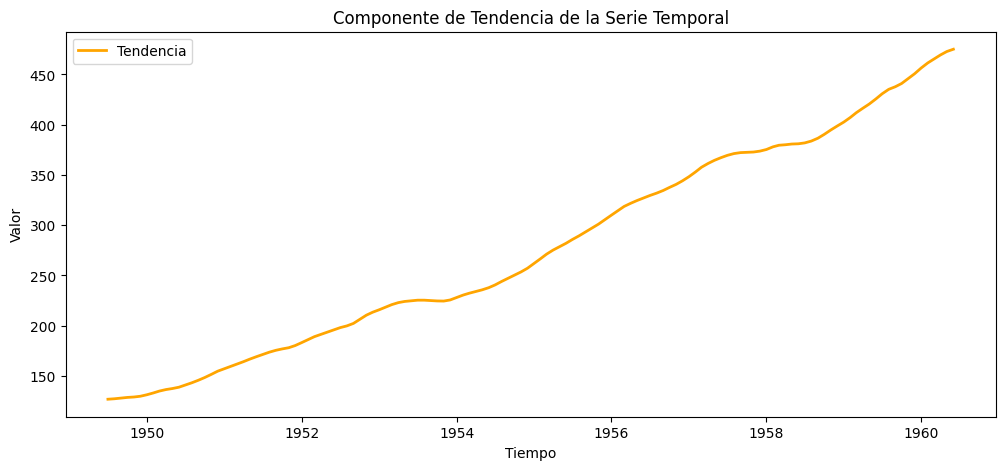

In [46]:
# Descomposición de la serie
result = seasonal_decompose(df['value'], model='additive', period=12)  # Ajusta period según los datos

# Graficar solo la tendencia
plt.figure(figsize=(12, 5))
plt.plot(result.trend, label='Tendencia', color='orange', linewidth=2)
plt.title("Componente de Tendencia de la Serie Temporal")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()


### Ejercicio 6

Visualiza todos los componentes de la serie temporal por separado

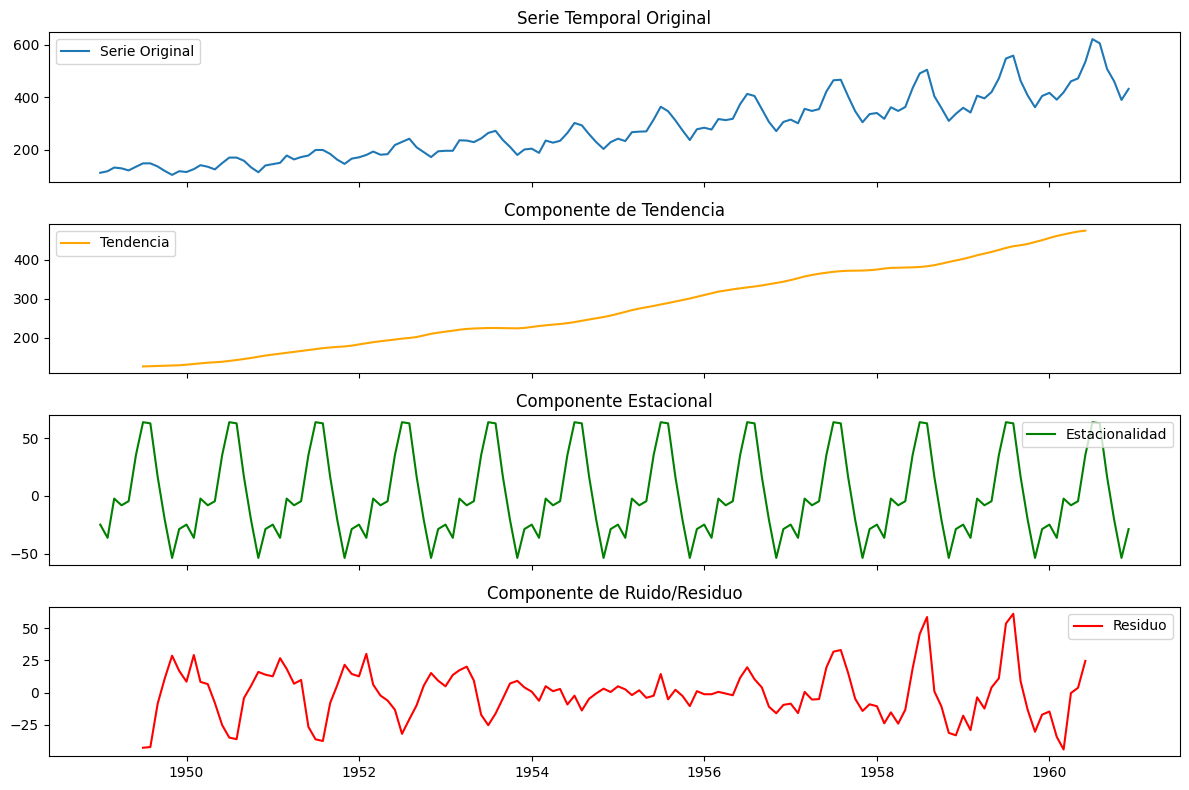

In [47]:
# Descomposición de la serie en tendencia, estacionalidad y residuo
result = seasonal_decompose(df['value'], model='additive', period=12)  # Ajusta period según los datos

# Crear la figura con subgráficos
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Graficar cada componente
axes[0].plot(df['value'], label='Serie Original')
axes[0].legend()
axes[0].set_title("Serie Temporal Original")

axes[1].plot(result.trend, label='Tendencia', color='orange')
axes[1].legend()
axes[1].set_title("Componente de Tendencia")

axes[2].plot(result.seasonal, label='Estacionalidad', color='green')
axes[2].legend()
axes[2].set_title("Componente Estacional")

axes[3].plot(result.resid, label='Residuo', color='red')
axes[3].legend()
axes[3].set_title("Componente de Ruido/Residuo")

plt.tight_layout()
plt.show()


### Ejercicio 7

Crea una matriz de correlación con los últimos 24 instantes (matriz de autocorrelación). Crea un dataframe con shift de 1 a 24 para ello, la idea es que puedas hacer una matriz de correlación con el valor actual y los 24 valores anteriores. Es decir de un mes con sus 23 meses anteriores. Interpreta la estacionalidad

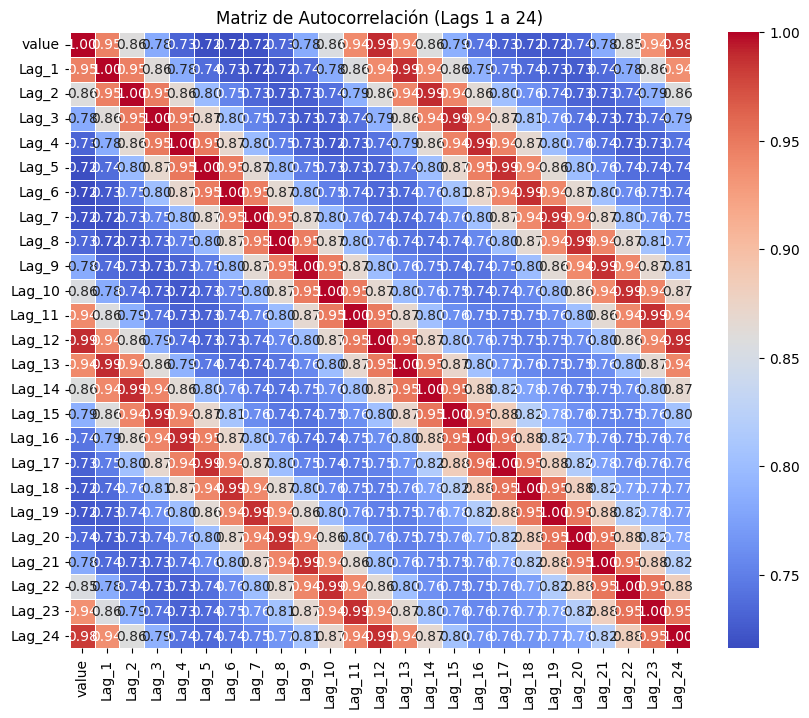

In [49]:
# Crear un DataFrame con lags (desplazamientos de 1 a 24)
df_lags = pd.DataFrame(df['value'])

for lag in range(1, 25):
    df_lags[f'Lag_{lag}'] = df['value'].shift(lag)

# Eliminar filas con valores NaN generados por el shift
df_lags.dropna(inplace=True)

# Calcular la matriz de correlación
corr_matrix = df_lags.corr()

# Graficar la matriz de correlación como mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Autocorrelación (Lags 1 a 24)")
plt.show()

### Ejercicio 8
Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

<Figure size 1000x500 with 0 Axes>

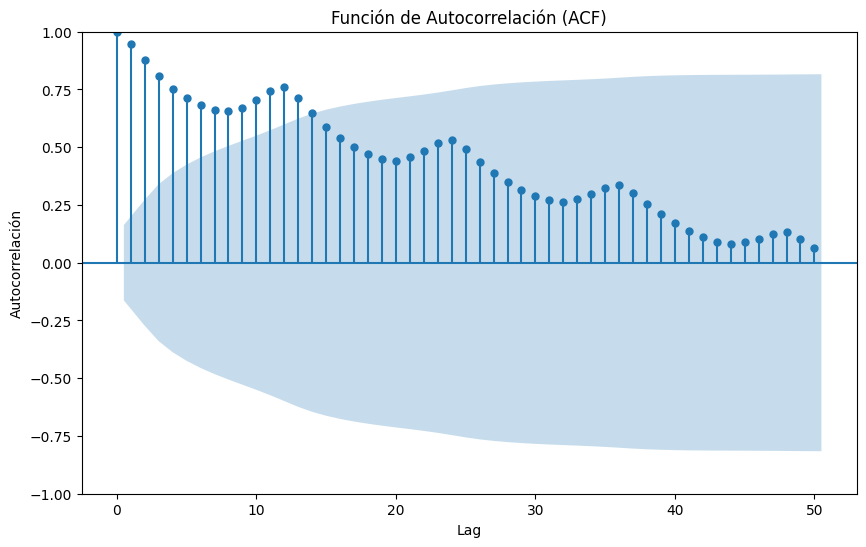

In [50]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Graficar la Función de Autocorrelación (ACF)
plt.figure(figsize=(10, 5))
plot_acf(df['value'].dropna(), lags=50)  # Ajusta lags según el contexto
plt.title("Función de Autocorrelación (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.show()

### Ejercicio 9

 Divide en train y test. En este caso no haremos división en validación, entre otras razones por la cantidad de datos que tenemos. Guarda 20 muestras para test.

In [51]:
# Definir el número de muestras para test
n_test = 20

# División en train y test
train = df.iloc[:-n_test]  # Todas las filas excepto las últimas 20
test = df.iloc[-n_test:]   # Últimas 20 filas

# Mostrar tamaños de cada conjunto
print(f"Tamaño del conjunto de entrenamiento: {len(train)} muestras")
print(f"Tamaño del conjunto de prueba: {len(test)} muestras")


Tamaño del conjunto de entrenamiento: 124 muestras
Tamaño del conjunto de prueba: 20 muestras


### Ejercicio 10

Pon en práctica lo visto en clases, crea un modelo de ARIMA (puedes utilizar autoarima), mide su RMSE y su MAPE. Comparalo gráficamente con los valores reales.

Parámetros óptimos ARIMA: (5, 1, 3)
RMSE: 113.16
MAPE: 17.15%


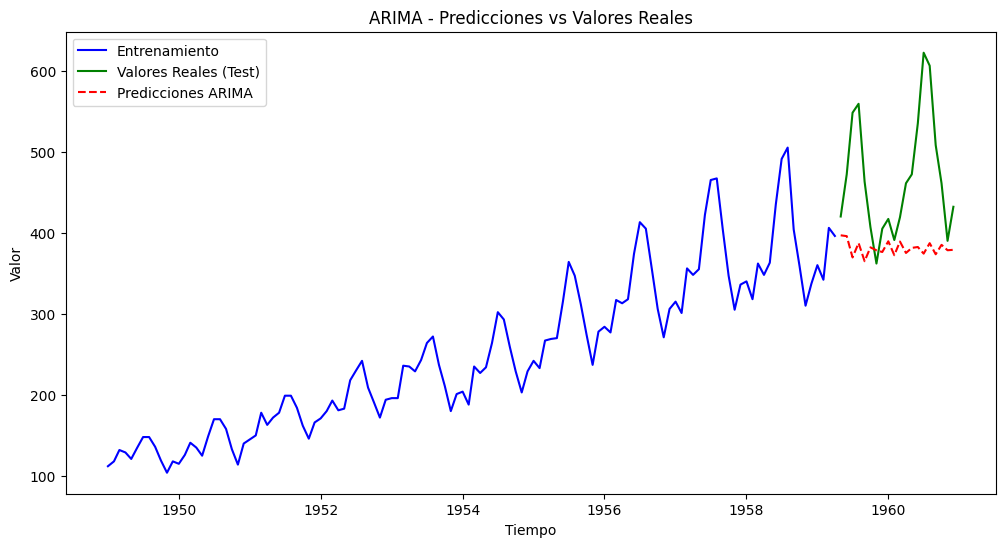

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1️⃣ División de datos
n_test = 20
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]

# 2️⃣ Encontrar los mejores parámetros con auto_arima
modelo_autoarima = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Parámetros óptimos ARIMA: {modelo_autoarima.order}")

# 3️⃣ Entrenar el modelo ARIMA con los mejores parámetros
modelo_arima = ARIMA(train, order=modelo_autoarima.order)
modelo_fit = modelo_arima.fit()

# 4️⃣ Hacer predicciones para el conjunto de prueba
predicciones = modelo_fit.forecast(steps=n_test)

# 5️⃣ Calcular RMSE y MAPE
rmse = np.sqrt(mean_squared_error(test, predicciones))
mape = mean_absolute_percentage_error(test, predicciones)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

# 6️⃣ Graficar predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Valores Reales (Test)', color='green')
plt.plot(test.index, predicciones, label='Predicciones ARIMA', color='red', linestyle='dashed')
plt.legend()
plt.title("ARIMA - Predicciones vs Valores Reales")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()


### Ejercicio 11

Haz lo mismo que en el ejercicio 10 pero con un modelo SARIMA. ¿Cuál es mejor y por qué?

Parámetros óptimos SARIMA: (1, 0, 0) × (0, 1, 0, 12)
RMSE: 33.86
MAPE: 6.35%


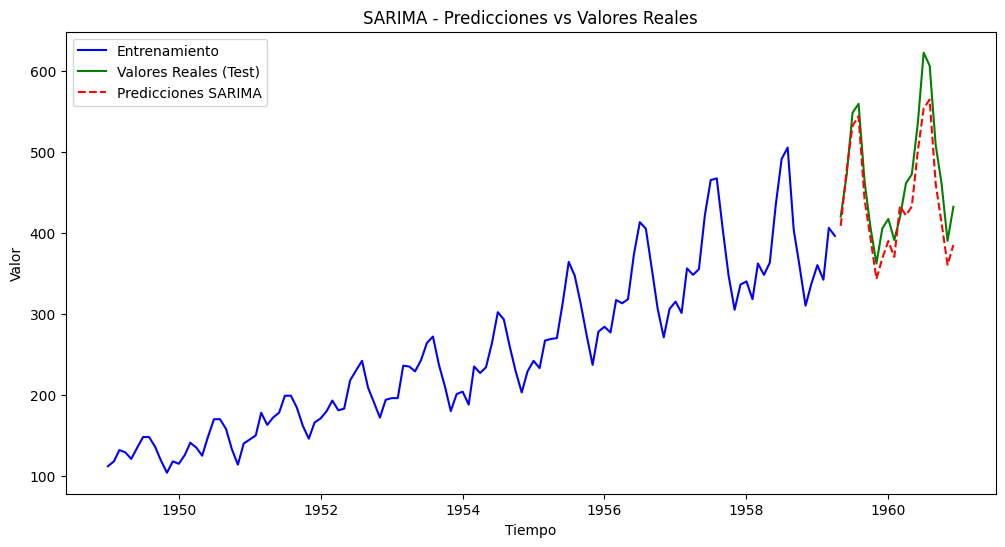

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 1️⃣ División de datos
n_test = 20
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]

# 2️⃣ Encontrar los mejores parámetros con auto_arima (SARIMA)
modelo_autoarima = auto_arima(
    train, seasonal=True, m=12,  # Ajusta 'm' según la estacionalidad detectada
    stepwise=True, suppress_warnings=True
)
print(f"Parámetros óptimos SARIMA: {modelo_autoarima.order} × {modelo_autoarima.seasonal_order}")

# 3️⃣ Entrenar el modelo SARIMA con los mejores parámetros
modelo_sarima = SARIMAX(train, order=modelo_autoarima.order, seasonal_order=modelo_autoarima.seasonal_order)
modelo_fit = modelo_sarima.fit()

# 4️⃣ Hacer predicciones para el conjunto de prueba
predicciones = modelo_fit.forecast(steps=n_test)

# 5️⃣ Calcular RMSE y MAPE
rmse = np.sqrt(mean_squared_error(test, predicciones))
mape = mean_absolute_percentage_error(test, predicciones)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

# 6️⃣ Graficar predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Entrenamiento', color='blue')
plt.plot(test.index, test, label='Valores Reales (Test)', color='green')
plt.plot(test.index, predicciones, label='Predicciones SARIMA', color='red', linestyle='dashed')
plt.legend()
plt.title("SARIMA - Predicciones vs Valores Reales")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()
